<a href="https://colab.research.google.com/github/cantaruttim/Rotinas/blob/main/Carteira_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import yfinance as yf
from datetime import date
import sys

In [3]:
# 'B3SA3.SA', 'BBAS3.SA', 'BBDC3.SA', 'CMIG4.SA', 'GGBR4.SA', 'ITSA4.SA', 'PETR4.SA', 'TAEE11.SA',
acoes = ['VINO11.SA', 'VGIA11.SA', 'GALG11.SA', 'VGHF11.SA']
data_atual = date.today()

dataset = yf.download(acoes, start='2023-01-04',end=data_atual)['Close']
dataset

[*********************100%%**********************]  4 of 4 completed


,GALG11.SA,VGHF11.SA,VGIA11.SA,VINO11.SA
Date,,,,
2023-01-04,9.13,9.14,9.91,9.436
2023-01-05,9.18,9.10,9.95,9.342
2023-01-06,9.11,9.11,9.98,9.580
2023-01-09,9.11,9.15,9.97,9.468
2023-01-10,9.13,9.19,9.99,9.404
...,...,...,...,...
2023-10-10,9.25,9.48,9.48,8.260
2023-10-11,9.25,9.50,9.52,8.310
2023-10-13,9.25,9.53,9.39,8.340


In [4]:
## valores atuais

vino = round(dataset['VINO11.SA'][-1], 5)
vgia = round(dataset['VGIA11.SA'][-2], 5)
vghf = round(dataset['VGHF11.SA'][-3], 5)
galg = round(dataset['GALG11.SA'][-4], 5)

vino, vgia, vghf, galg

(8.39, 9.37, 9.53, 9.25)

In [5]:
## valores médio de cada ação

# dataset.describe().T

mGALG = round(dataset['GALG11.SA'].mean(), 2)
mVGHF = round(dataset['VGHF11.SA'].mean(), 2)
mVGIA = round(dataset['VGIA11.SA'].mean(), 2)
mVINO = round(dataset['VINO11.SA'].mean(), 2)

mGALG, mVGHF, mVGIA, mVINO

(8.85, 9.3, 9.58, 8.8)

In [6]:
dataset.to_csv('acoes.csv')

In [7]:
def alocacao_ativos(dataset, dinheiro_total, seed = 0, melhores_pesos = []):
  dataset = dataset.copy()

  if seed != 0:
    np.random.seed(seed)

  if len(melhores_pesos) > 0:
    pesos = melhores_pesos
  else:
    pesos = np.random.random(len(dataset.columns) - 1)
    pesos = pesos / pesos.sum()


  colunas = dataset.columns[1:]
  for i in colunas:
    dataset[i] = (dataset[i] / dataset[i][0])

  for i, acao in enumerate(dataset.columns[1:]):
    dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

  dataset['soma valor'] = dataset.sum(axis = 1)

  datas = dataset['Date']

  dataset.drop(labels = ['Date'], axis = 1, inplace = True)
  dataset['taxa retorno'] = 0.0

  for i in range(1, len(dataset)):
    dataset['taxa retorno'][i] = ((dataset['soma valor'][i] / dataset['soma valor'][i - 1]) - 1) * 100

  acoes_pesos = pd.DataFrame(data = {'Ações': colunas, 'Pesos': pesos * 100})

  return dataset, datas, acoes_pesos, dataset.loc[len(dataset) - 1]['soma valor']

In [8]:
dataset, datas, acoes_pesos, soma_valor = alocacao_ativos(pd.read_csv('acoes.csv'), 250, 10);

<ipython-input-7-9a39134fcf29>:21: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset['soma valor'] = dataset.sum(axis = 1)


In [9]:
dataset

,GALG11.SA,VGHF11.SA,VGIA11.SA,VINO11.SA,soma valor,taxa retorno
0,88.676923,2.385803,72.849050,86.088224,250.000000,0.000000
1,89.162560,2.375362,73.143092,85.230628,249.911641,-0.035343
2,88.482665,2.377972,73.363622,87.401992,251.626250,0.686086
3,88.482665,2.388413,73.290117,86.380177,250.541372,-0.431147
4,88.676923,2.398854,73.437134,85.796280,250.309191,-0.092671
...,...,...,...,...,...,...
192,89.842446,2.474552,69.688090,75.359131,237.364219,-0.568822
193,89.842446,2.479773,69.982139,75.815302,238.119660,0.318262
194,89.842446,2.487604,69.026500,76.089001,237.445550,-0.283097
195,88.774052,2.482383,68.879475,75.724066,235.859977,-0.667763


In [10]:
def evolucao_acoes(dataset, datas):

  figura = px.line(title = "Evolução do Patrimônio")
  for i in dataset.drop(columns = ['soma valor', 'taxa retorno']).columns:
    figura.add_scatter(x = datas, y = dataset[i], name = i)
    figura.update_layout(hovermode="x")

  return figura.show()

evolucao_acoes(dataset, datas)

In [11]:
def evolucao_patrimonio_investido(dataset, datas):

  figura = px.line(x = datas,
                  y = dataset['soma valor'],
                  title = 'Evolução do Patrimônio')
  return figura.show()

evolucao_patrimonio_investido(dataset, datas)

## Sharpe Ratio

In [ ]:
## média histórica da selic nos últimos
taxa_selic_historico  = np.array([13.65, 12.83, 4.98, 2.55, 5.68])
np.mean(taxa_selic_historico)

In [ ]:
np.mean(taxa_selic_historico)

7.938

In [ ]:
def alocacao_portfolio(dataset, dinheiro_total, sem_risco, repeticoes):
  dataset = dataset.copy()
  dataset_original = dataset.copy()

  lista_retorno_esperado = []
  lista_volatilidade_esperada = []
  lista_sharpe_ratio = []

  melhor_sharpe_ratio = 1 - sys.maxsize
  melhores_pesos = np.empty
  melhor_volatilidade = 0
  melhor_retorno = 0

  for _ in range(repeticoes):
    pesos = np.random.random(len(dataset.columns) - 1)
    pesos = pesos / pesos.sum()

    for i in dataset.columns[1:]:
      dataset[i] = dataset[i] / dataset[i][0]

    for i, acao in enumerate(dataset.columns[1:]):
      dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

    dataset.drop(labels = ['Date'], axis = 1, inplace=True)

    retorno_carteira = np.log(dataset / dataset.shift(1))
    matriz_covariancia = retorno_carteira.cov()

    dataset['soma valor'] = dataset.sum(axis = 1)
    dataset['taxa retorno'] = 0.0

    for i in range(1, len(dataset)):
      dataset['taxa retorno'][i] = np.log(dataset['soma valor'][i] / dataset['soma valor'][i - 1])

    #sharpe_ratio = (dataset['taxa retorno'].mean() - sem_risco) / dataset['taxa retorno'].std() * np.sqrt(246)
    retorno_esperado = np.sum(dataset['taxa retorno'].mean() * pesos) * 246
    volatilidade_esperada = np.sqrt(np.dot(pesos, np.dot(matriz_covariancia * 246, pesos)))
    sharpe_ratio = (retorno_esperado - sem_risco) / volatilidade_esperada

    if sharpe_ratio > melhor_sharpe_ratio:
      melhor_sharpe_ratio = sharpe_ratio
      melhores_pesos = pesos
      melhor_volatilidade = volatilidade_esperada
      melhor_retorno = retorno_esperado

    lista_retorno_esperado.append(retorno_esperado)
    lista_volatilidade_esperada.append(volatilidade_esperada)
    lista_sharpe_ratio.append(sharpe_ratio)

    dataset = dataset_original.copy()

  return melhor_sharpe_ratio, melhores_pesos, lista_retorno_esperado, lista_volatilidade_esperada, lista_sharpe_ratio, melhor_volatilidade, melhor_retorno

In [ ]:
sharpe_ratio, melhores_pesos, ls_retorno, ls_volatilidade, ls_sharpe_ratio, melhor_volatilidade, melhor_retorno = alocacao_portfolio(pd.read_csv('acoes.csv'),
                                                                                                                                     250,
                                                                                                                                     taxa_selic_historico.mean() / 100,
                                                                                                                                     15000)

In [ ]:
## 100, 5000 => 1.2454374630888962
## 250, 15000 => 1.223707391614204

sharpe_ratio

-0.39324408279758266

In [ ]:
melhores_pesos

array([0.14495296, 0.83287261, 0.0166858 , 0.00548863])

In [ ]:
_, _, acoes_pesos, soma_valor = alocacao_ativos(pd.read_csv('acoes.csv'), 250, melhores_pesos=melhores_pesos)

<ipython-input-22-9a39134fcf29>:21: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [ ]:
acoes_pesos, soma_valor

(       Ações      Pesos
 0  GALG11.SA  14.495296
 1  VGHF11.SA  83.287261
 2  VGIA11.SA   1.668580
 3  VINO11.SA   0.548863,
 258.0761537124367)

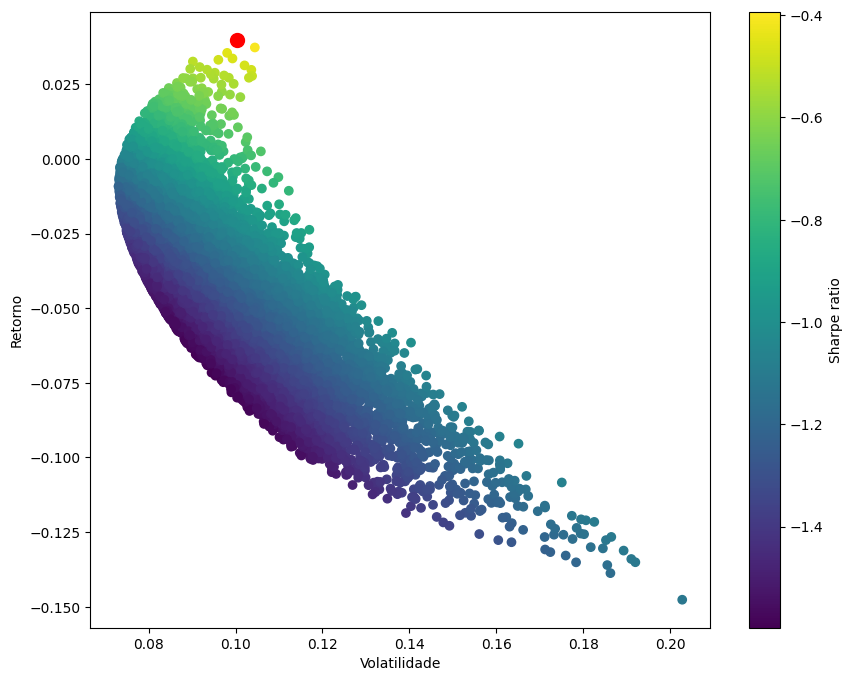

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(ls_volatilidade, ls_retorno, c = ls_sharpe_ratio)
plt.colorbar(label = 'Sharpe ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(melhor_volatilidade, melhor_retorno, c = 'red', s = 100);

## Fundo de Investimentos

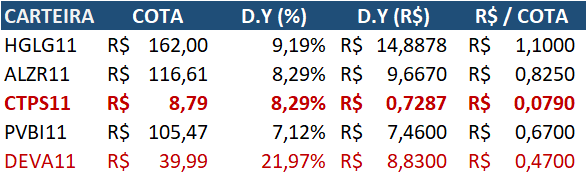

### Funções testes

In [ ]:
round(sum(df.iloc[:, 5].values), 2)

4113.56

In [19]:
def periodo(meses):
  mesesLista = []
  for meses in range(1, meses + 1):
      mesesLista.append(f"MÊS {meses}")
  return mesesLista

meses = periodo(10)

In [20]:
def seleciona_empresa(qtd_empresas):
  tickers = []
  analise = []

  for j in range(qtd_empresas):
      empresa = input(f"Ticker da empresa {j + 1}: ")
      tickers.append(empresa)

  for n in range(len(df['CARTEIRA'])):
      if df['CARTEIRA'][n] in tickers:
          analise.append(df.iloc[n])

  analise = pd.DataFrame(analise)

  return analise

lista_completa = seleciona_empresa(4)
lista_completa

Ticker da empresa 1: VINO11
Ticker da empresa 2: GALG11
Ticker da empresa 3: VGHF11
Ticker da empresa 4: VGIA11


,CARTEIRA,COTA,D.Y %,R$ / COTA,MAGIC NUMBER,INVESTIMENTO (MG),# COTAS,RETORNO MENSAL
0,VINO11,9.52,13.31,0.060,159.0,1513.68,26.0,1.56
1,VGIA11,9.39,19.17,0.130,72.0,676.08,27.0,3.51
2,GALG11,9.25,10.68,0.084,110.0,1017.50,27.0,2.27
3,VGHF11,9.54,13.31,0.100,95.0,906.30,26.0,2.60


## Tratamentos

In [12]:
import pandas as pd
# "CARTEIRA": ['HGLG11', 'ALZR11', 'CTPS11', 'PVBI11', 'DEVA11', 'VINO11', 'VGIA11', 'GALG11', 'VGHF11']


## TAXA SELIC EM %
taxa_selic_historico  = np.array([0.1365, 0.1283, 0.0498, 0.0255, 0.0568])
taxa_media_juros = round(np.mean(taxa_selic_historico), 5)
taxa_media_juros


aporteInicial = int(input("Quanto deseja investir mensalmente? "))
# meses = int(input("Para quantos meses gostaria de realizar a projeção? "))

# total = aporteInicial * meses

FII = {"CARTEIRA": ['VINO11', 'VGIA11', 'GALG11', 'VGHF11'],
       "COTA": [vino, vgia, galg, vghf], ## pegamos os valores atuais do mercado (d - 1)
       "D.Y %": [13.31, 19.17, 10.68, 13.31],
       "R$ / COTA":[0.0600, 0.1300, 0.0840, 0.1000]} ## valor de pagamento por cota (mensal)
df = pd.DataFrame(FII)

## MG necessário para o escalonamento
df['MAGIC NUMBER'] = (df['COTA'] / df['R$ / COTA'])
df['MAGIC NUMBER'] = round(df['MAGIC NUMBER'], 0)

## Alocação (por frequência relativa para cada ação -- com base no preço total necessário)
df["INVESTIMENTO (MG)"] = df['COTA'] * df['MAGIC NUMBER']
df["INVESTIMENTO (MG)"] = round(df["INVESTIMENTO (MG)"], 2)

## QUAL O VALOR DO RETORNO AO ATINGIR O MG?
valor_investido = aporteInicial
df['# COTAS'] = (valor_investido / df['COTA'])
df['# COTAS'] = round(df['# COTAS'], 0)

## retorno mensal
df['RETORNO MENSAL'] = df['R$ / COTA'] * df['# COTAS']
df['RETORNO MENSAL'] = round(df['RETORNO MENSAL'], 3)

df = df.copy()
df

Quanto deseja investir mensalmente? 200


,CARTEIRA,COTA,D.Y %,R$ / COTA,MAGIC NUMBER,INVESTIMENTO (MG),# COTAS,RETORNO MENSAL
0,VINO11,8.39,13.31,0.060,140.0,1174.60,24.0,1.440
1,VGIA11,9.37,19.17,0.130,72.0,674.64,21.0,2.730
2,GALG11,9.25,10.68,0.084,110.0,1017.50,22.0,1.848
3,VGHF11,9.53,13.31,0.100,95.0,905.35,21.0,2.100


In [13]:
aporteMensal = int(input("Qual seria o valor do aporte Mensal? "))
meses = int(input("Qual seria o período de investimento? "))
totalPeriodo = aporteMensal * meses
#### APLICAÇÃO DA ESTRATÉGIA

df['%'] = round(df.iloc[:, 5] / df.iloc[:, 5].sum(), 4)
df['Valor Aporte'] = round(df['%'] * totalPeriodo, 2)

#                             QTD COTAS POR MES COM APORTE MENSAL + COTAS ATUAIS
df['Cotas no Periodo'] = round( ((df['Valor Aporte']/df['COTA'])) + df['# COTAS'], 0)


# retorno para o período
df['RETORNO PERIODO'] = df['Cotas no Periodo'] * df['R$ / COTA']

df

Qual seria o valor do aporte Mensal? 250
Qual seria o período de investimento? 24


,CARTEIRA,COTA,D.Y %,R$ / COTA,MAGIC NUMBER,INVESTIMENTO (MG),# COTAS,RETORNO MENSAL,%,Valor Aporte,Cotas no Periodo,RETORNO PERIODO
0,VINO11,8.39,13.31,0.060,140.0,1174.60,24.0,1.440,0.3114,1868.4,247.0,14.820
1,VGIA11,9.37,19.17,0.130,72.0,674.64,21.0,2.730,0.1789,1073.4,136.0,17.680
2,GALG11,9.25,10.68,0.084,110.0,1017.50,22.0,1.848,0.2697,1618.2,197.0,16.548
3,VGHF11,9.53,13.31,0.100,95.0,905.35,21.0,2.100,0.2400,1440.0,172.0,17.200


In [14]:
import numpy as np

meses = int(input("Projeção para quantos meses: "))

def FIIS(meses, taxa_media_juros, retorno_inicial):

    resultados = [retorno_inicial]

    for j in range(meses + 1):
        resultados.append(round((resultados[j] * taxa_media_juros) + resultados[j], 2))
    return resultados

resultados = FIIS(meses, taxa_media_juros , df.iloc[:, -1])
resultados

Projeção para quantos meses: 48


[0    14.820
 1    17.680
 2    16.548
 3    17.200
 Name: RETORNO PERIODO, dtype: float64,
 0    16.00
 1    19.08
 2    17.86
 3    18.57
 Name: RETORNO PERIODO, dtype: float64,
 0    17.27
 1    20.59
 2    19.28
 3    20.04
 Name: RETORNO PERIODO, dtype: float64,
 0    18.64
 1    22.22
 2    20.81
 3    21.63
 Name: RETORNO PERIODO, dtype: float64,
 0    20.12
 1    23.98
 2    22.46
 3    23.35
 Name: RETORNO PERIODO, dtype: float64,
 0    21.72
 1    25.88
 2    24.24
 3    25.20
 Name: RETORNO PERIODO, dtype: float64,
 0    23.44
 1    27.93
 2    26.16
 3    27.20
 Name: RETORNO PERIODO, dtype: float64,
 0    25.30
 1    30.15
 2    28.24
 3    29.36
 Name: RETORNO PERIODO, dtype: float64,
 0    27.31
 1    32.54
 2    30.48
 3    31.69
 Name: RETORNO PERIODO, dtype: float64,
 0    29.48
 1    35.12
 2    32.90
 3    34.21
 Name: RETORNO PERIODO, dtype: float64,
 0    31.82
 1    37.91
 2    35.51
 3    36.93
 Name: RETORNO PERIODO, dtype: float64,
 0    34.35
 1    40.92
 2  

In [15]:
for i in range(len(resultados)):
  total = resultados[i].sum()
print(f"Total ganho no período foi de R$ {total:.2f} reais")

Total ganho no período foi de R$ 2796.25 reais


In [16]:
emp = int(input("Quantas empresa deseja comparar? "))

def seleciona_empresa(qtd_empresas):
  tickers = []
  analise = []

  for j in range(qtd_empresas):
      empresa = input(f"Ticker da empresa {j + 1}: ")
      tickers.append(empresa)

  for n in range(len(df['CARTEIRA'])):
      if df['CARTEIRA'][n] in tickers:
          analise.append(df.iloc[n])

  analise = pd.DataFrame(analise)

  return analise, tickers

lista_completa, tickers = seleciona_empresa(emp)

meses = int(input("Projeção para quantos meses: "))

def FIIS(meses, empresas, taxa_media_juros, retorno_inicial):

    resultados = [retorno_inicial]

    ## ADD O APORTE MENSAL

    for j in range(meses + 1):
        resultados.append(  round((resultados[j] * taxa_media_juros) + resultados[j], 3)  )

    ## retornando a soma total no final do período
    resultados[-1], print(f"O valor do rendimento em {meses} meses é de R$ {sum(resultados[-1]):.2f} reais")

    return resultados

resultados = FIIS(meses, lista_completa, taxa_media_juros, lista_completa.iloc[:, -1])

Quantas empresa deseja comparar? 3
Ticker da empresa 1: VINO11
Ticker da empresa 2: GALG11
Ticker da empresa 3: VGIA11
Projeção para quantos meses: 48
O valor do rendimento em 48 meses é de R$ 2070.93 reais


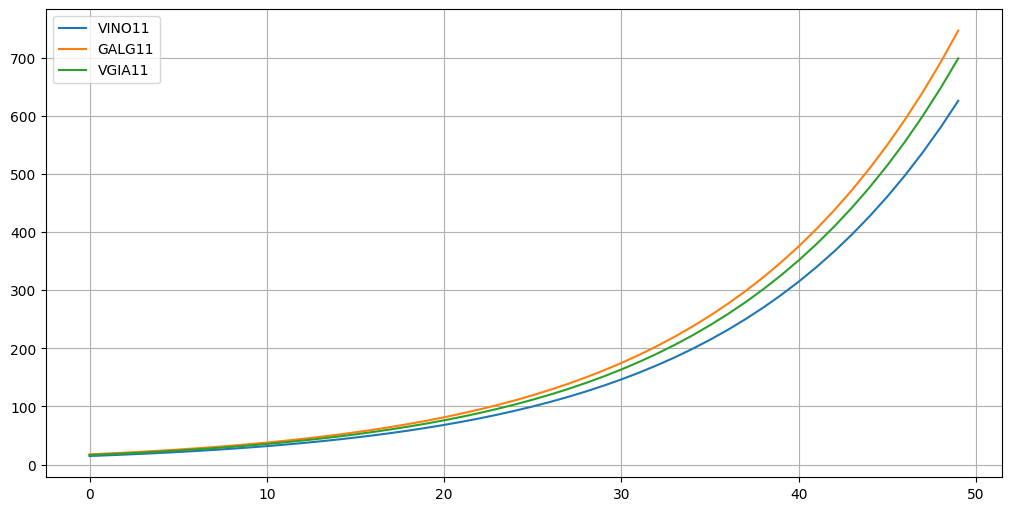

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5), layout = "constrained")

ax.plot(resultados, label = tickers)

ax.legend(loc="upper left")
ax.grid(True)

In [18]:
## pegando o último índice da lista e somar todos os valores
resultados[-1], print(f"O valor do rendimento em {meses} meses é de R$ {sum(resultados[-1]):.2f}")

O valor do rendimento em 48 meses é de R$ 2070.93


(0    625.740
 1    746.487
 2    698.702
 Name: RETORNO PERIODO, dtype: float64,
 None)